## data preparation

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices())

2023-11-11 13:15:22.837111: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-11 13:15:23.045258: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-11 13:15:23.045311: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-11 13:15:23.046023: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-11 13:15:23.122584: I tensorflow/core/platform/cpu_feature_g

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-11-11 13:15:26.126368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-11 13:15:26.154554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-11 13:15:26.154859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
import sys
ABS_ROOT_DIR_PATH = '/host/dissertation/'
if ABS_ROOT_DIR_PATH not in sys.path:
    sys.path.append(ABS_ROOT_DIR_PATH)

In [3]:
import numpy as np
POINTS_NUM = 10
points = np.load(f'/host/dissertation/proccessed_data/points_{POINTS_NUM}.npy')
# pt = np.load('/host/dissertation/proccessed_data/pt.npy')
pt = (np.load('/host/dissertation/proccessed_data/pt.npy')-1.)/9.

In [4]:
# points_norms = [np.abs(row[0]-row[1]-row[2]) for row in points]
print(np.min(pt), np.max(pt))

9.267859988742405e-05 0.9991803699069552


## manual testing

In [125]:
import cvnn.layers as complex_layers

# from common.model import sigmoid_real_with_abs
from tensorflow import Tensor
from tensorflow.keras.activations import sigmoid, relu
def sigmoid_real_with_abs(z: Tensor) -> Tensor:
    return sigmoid(tf.math.abs(z))
def capped_relu_with_abs(z: Tensor) -> Tensor:
    return tf.math.reduce_min(relu(tf.math.abs(z)),1)

model = tf.keras.models.Sequential()
model.add(complex_layers.ComplexInput(input_shape=(POINTS_NUM,)))
model.add(complex_layers.ComplexDense(units=32, activation='pol_sigmoid'))
model.add(complex_layers.ComplexDense(units=32, activation='pol_sigmoid'))
model.add(complex_layers.ComplexDense(units=1, activation='convert_to_real_with_abs')) #'convert_to_real_with_abs'
model.compile(optimizer=tf.keras.optimizers.SGD(clipnorm=1.), loss='mean_squared_error', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 complex_dense (ComplexDens  (None, 32)                704       
 e)                                                              
                                                                 
 complex_dense_1 (ComplexDe  (None, 32)                2112      
 nse)                                                            
                                                                 
 complex_dense_2 (ComplexDe  (None, 1)                 66        
 nse)                                                            
                                                                 
Total params: 2882 (11.26 KB)
Trainable params: 2882 (11.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [123]:
from common.model import FreeMemory

history = model.fit(points, pt, epochs=250, validation_split=0.2, verbose=0, callbacks=[FreeMemory(10)])

epoch 0 ended, info: {'loss': 0.11731825023889542, 'mean_absolute_error': 0.27331650257110596, 'val_loss': 0.08841703087091446, 'val_mean_absolute_error': 0.25549179315567017}
epoch 10 ended, info: {'loss': 0.07840188592672348, 'mean_absolute_error': 0.23865364491939545, 'val_loss': 0.10120850056409836, 'val_mean_absolute_error': 0.26882997155189514}
epoch 20 ended, info: {'loss': 0.07400932163000107, 'mean_absolute_error': 0.23106110095977783, 'val_loss': 0.07182526588439941, 'val_mean_absolute_error': 0.22989840805530548}
epoch 30 ended, info: {'loss': 0.06788833439350128, 'mean_absolute_error': 0.21808482706546783, 'val_loss': 0.07811519503593445, 'val_mean_absolute_error': 0.23860497772693634}
epoch 40 ended, info: {'loss': 0.06801909953355789, 'mean_absolute_error': 0.21990741789340973, 'val_loss': 0.11836642026901245, 'val_mean_absolute_error': 0.28525105118751526}
epoch 50 ended, info: {'loss': 0.06538800895214081, 'mean_absolute_error': 0.2153293937444687, 'val_loss': 0.0913588

1st percentile of train loss:       3.4027e-02
1st percentile of validation loss:  2.8997e-02


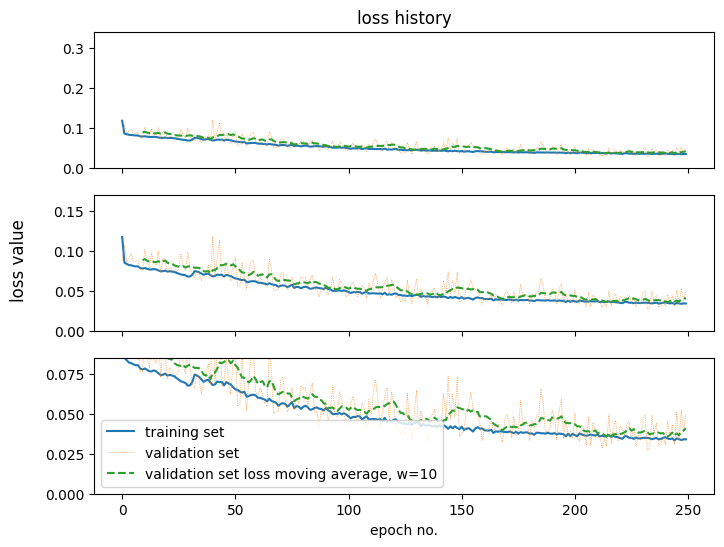

In [124]:
from common.plot import plot_metric_history_zoomed
plot_metric_history_zoomed(history, moving_average_window = (10,))

## space search

In [7]:
from common.search import ConfigsTester

configs_tester = ConfigsTester(spacepoints_number_space = [10,6],
                               hiddenlayers_number_space = [1,2,3,],
                               hiddenlayers_neurons_number_space = [128,64,],
                               hiddenlayers_activation_func_space = ['pol_sigmoid','pol_tanh','cart_sigmoid','cart_relu',],
                               outputlayer_activation_func_space = ['sigmoid_real', 'convert_to_real_with_abs',],
                               metric = 'loss')

In [8]:
import cvnn.layers as complex_layers
from common.model import FreeMemory

configs_tester.test_configs(y_data=pt,
                            optimizer_factory=lambda: tf.keras.optimizers.SGD(clipnorm=1.), 
                            loss='mean_squared_error', 
                            epochs=250, 
                            callbacks=[FreeMemory()])

START (10, 1, 128, 'pol_sigmoid', 'sigmoid_real')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (10, 1, 128, 'pol_sigmoid', 'sigmoid_real')
START (10, 1, 128, 'pol_sigmoid', 'convert_to_real_with_abs')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (10, 1, 128, 'pol_sigmoid', 'convert_to_real_with_abs')
START (10, 1, 128, 'pol_tanh', 'sigmoid_real')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (10, 1, 128, 'pol_tanh', 'sigmoid_real')
START (10, 1, 128, 'pol_tanh', 'convert_to_real_with_abs')
      model compiled
      training...
      model trained
      hp_file appended
      history saved
      weights saved
DONE  (10, 1, 128, 'pol_tanh', 'convert_to_real_with_abs')
START (10, 1, 128, 'cart_sigmoid', 'sigmoid_real')
      model compiled
    